# BA878 Homework 2

# Problem 1: Classification

The following blocks of code only download the data that will be processed programmatically, but it might be useful look at some of the files manually to answer some of the questions.

To download the data, you first need to create a Kaggle account.

Click on your profile in the top right and then click on the *Account* tab.

Under the API section, click on *Create New API Token*. This will download a file called *kaggle.json* that contains your credentials. Then, run the code block below, which will eventually prompt you to upload the *kaggle.json* file by clicking on the "Choose Files" button.

In [ ]:
# Download the CDC Death Counts for COVID-19 dataset

# Upload your kaggle.json file by running this piece of code
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prateeknaharia","key":"b8c41daab77d99bf3e7051081a9b2a2d"}'}

In [ ]:
# Download the CDC deaths dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d cdc/mortality

kaggle.json
100% 730M/731M [00:08<00:00, 141MB/s]
100% 731M/731M [00:08<00:00, 94.4MB/s]


In [ ]:
# Unzip the zip file
!unzip -q mortality.zip -d .

## Download and Preprocess the Dataset

In [ ]:
import pandas as pd
import numpy as np
import json

# Load the 2015 subset of the CDC dataset into a pandas dataframe
df = pd.read_csv("/content/2015_data.csv", header=0, dtype=object)
columns = ['resident_status', 'education_2003_revision', 'month_of_death',
           'sex', 'detail_age', 'age_recode_12',
           'place_of_death_and_decedents_status', 'marital_status',
           'day_of_week_of_death','injury_at_work', 'manner_of_death',
           'autopsy', 'activity_code', '39_cause_recode', 'race']
df = df[columns]
df = df[df['autopsy']!='U']
df.dropna(subset = columns, inplace = True)

# View the first few rows of the dataset
df.head()

,resident_status,education_2003_revision,month_of_death,sex,detail_age,age_recode_12,place_of_death_and_decedents_status,marital_status,day_of_week_of_death,injury_at_work,manner_of_death,autopsy,activity_code,39_cause_recode,race
3,1,3,01,F,040,06,4,S,5,N,3,Y,9,41,03
9,1,9,01,F,093,11,6,W,7,U,7,N,9,39,01
15,1,3,01,M,032,05,1,S,6,N,1,N,9,39,03
16,1,2,01,M,018,04,7,S,1,N,2,N,9,40,03
17,1,3,01,M,048,07,4,M,7,N,2,N,9,40,01


In [ ]:
with open('2015_codes.json') as json_data:
    codes = json.load(json_data)

In machine learning, classification is the process of categorizing data into different classes. Here, you will learn to use popular libraries such as scikit-learn to tackle such classification problems.

First, let's get familiar with the dataset that will be used for this classification problem: the CDC mortality dataset. Every year the CDC releases the country’s most detailed report on death in the United States. The files that were downloaded above include these reports between 2005 and 2015. In this problem, we will only consider the mortality data from 2015.

We will start off by taking a look at this dataset and the information it contains.

## 1. Data exploration

In [ ]:
# 1.a)
# Q: How many individuals does the dataset contain information about?
# Hint: How can you find the number of rows in a pandas dataframe?
# --- YOUR CODE HERE ---
df.shape[0]
# --- YOUR CODE ENDS ---

198415

The information contained in the dataframe is coded according to conventions that are given in the 2015_codes.json file. Run the cell below to print a list of all available features

In [ ]:
print(f"List of available features: {list(df.columns)}")
print(f"Day of week codes: {codes['day_of_week_of_death']}")

List of available features: ['resident_status', 'education_2003_revision', 'month_of_death', 'sex', 'detail_age', 'age_recode_12', 'place_of_death_and_decedents_status', 'marital_status', 'day_of_week_of_death', 'injury_at_work', 'manner_of_death', 'autopsy', 'activity_code', '39_cause_recode', 'race']
Day of week codes: {'1': 'Sunday', '2': 'Monday', '3': 'Tuesday', '4': 'Wednesday', '5': 'Thursday', '6': 'Friday', '7': 'Saturday', '9': 'Unknown'}


In [ ]:
# 1.b)
# Q: On what day of the week did the death occur? What was the cause of death?
# Hint: You can answer these questions by printing out row 1357 in the dataframe
# How can you do that?
# --- YOUR CODE HERE ---
row1357 = df.iloc[1357]
dayofdeath = row1357['day_of_week_of_death']
causeofdeath = row1357['39_cause_recode']
print(dayofdeath)
print(causeofdeath)
print(row1357)
# cause_of_death = row_1357['39_cause_recode']
# --- YOUR CODE ENDS ---

4
38
resident_status                          2
education_2003_revision                  4
month_of_death                          02
sex                                      M
detail_age                             021
age_recode_12                           04
place_of_death_and_decedents_status      1
marital_status                           S
day_of_week_of_death                     4
injury_at_work                           N
manner_of_death                          1
autopsy                                  N
activity_code                            9
39_cause_recode                         38
race                                    01
Name: 62688, dtype: object




*   The day of the week of death was the 4th day, which typically corresponds to Wednesday.

*   The cause of death is coded as 38. Without a reference for the codes, we can only identify it as "Cause 38".

38 refers to Motor vehicle accidents.



## 2. Binary classification

In problem set 1, we simply fit a Random Forest classifier to all of the available data. In practice, we would like to know how well our model performs on *out-of-sample* data, that is, data that it was not fit to.

The following block of code splits the data into a training set (70% of the available data) and a test set (the remaining 30% of the data). The training set will be used to "train", or fit our model. The test set will be used to evaluate our model's performance on data that it hasn't seen before.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, train_size = 0.7, random_state = 7)
model_columns = ['resident_status','education_2003_revision','month_of_death',
                 'sex','detail_age','age_recode_12',
                 'place_of_death_and_decedents_status','marital_status',
                 'day_of_week_of_death','injury_at_work','manner_of_death',
                 'activity_code','39_cause_recode','race']

# The features are the data that the model will take as input
train_features = train_df[model_columns].to_numpy()
test_features = test_df[model_columns].to_numpy()

# The targets are the ground truth labels that we want our model
# to correctly predict
train_target = train_df['autopsy'].to_numpy()
test_target = test_df['autopsy'].to_numpy()

### 1. Random Forest

In the cell below, we proceed to first one-hot encode features. This is necessary because the RandomForestClassifier from sklearn is not implemented to handle categorical features such as the marital status of decedents (Single, Married, Divorced, Widowed or Unknown). This encoding creates binary features for each category of a categorical feature. In the case of marital status, this creates 5 binary features: Single (True or False), Married (True or False), etc. Consequently, for each row, only one of these 5 binary features will be True, all the others will be False.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

# Create a one hot encoder and fit it to all the data (train + test splits)
enc = OneHotEncoder()
enc.fit(np.concatenate((train_features, test_features)))

# One-hot encode each of the train and test splits, and store the results in
# X_train and X_test respectively
X_train = enc.transform(train_features)
X_test = enc.transform(test_features)

From this point onwards, you should have at your disposal four variables that you can use for training your models:
- X_train: containing the training split features that the model will use as input
- X_test: containing the test split features that the model will use as input
- train_target: containing the ground truth labels for the training set that the model should try to predict
- test_target: containing the ground truth labels for the test set that the model should try to predict

In the following block, write code to create and train a RandomForestClassifier using the scikit-learn library. It might be useful to refer to the examples in the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest#sklearn.ensemble.RandomForestClassifier) for an idea of how to start.

In [ ]:
# 2.a)
# Create a random forest classifier named clf
# Use max_depth=10 and random_state=7
# --- YOUR CODE HERE ---
clf = RandomForestClassifier(max_depth=10, random_state=7)
# --- YOUR CODE ENDS ---

# Fit clf to the training data
# What variables should you pass to the fit function?
# --- YOUR CODE HERE ---
clf.fit(X_train, train_target)
# --- YOUR CODE ENDS ---

# Use clf to predict the labels on the test set, and store the results in
# a variable named predicted_target_rf
# --- YOUR CODE HERE ---
predicted_target_rf = clf.predict(X_test)
# --- YOUR CODE ENDS ---

### 2. Logistic Regression

Similarly to what we did above, we will now train a LogisticRegression model using the scikit-learn library. The code will be very similar to that of the RandomForestClassifier, but please feel free to refer to the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression) for guidance on how to use the LogisticRegression class.

In [ ]:
from sklearn.linear_model import LogisticRegression

# 2.a) (continued)
# Create a logistic regression model named logit.
# Use random_state=7 and max_iter=1000
# --- YOUR CODE HERE ---
logit = LogisticRegression(random_state=7, max_iter=1000)
# --- YOUR CODE ENDS ---

# Fit logit to the training data
# What variables should you pass to the fit function?
# --- YOUR CODE HERE ---
logit.fit(X_train, train_target)
# --- YOUR CODE ENDS ---

# Use logit to predict the labels on the test set, and store the results in
# a variable named predicted_target_lr
# --- YOUR CODE HERE ---
predicted_target_lr = logit.predict(X_test)
# --- YOUR CODE ENDS ---

So far, we have trained a RandomForestClassifier and a LogisticRegression classifier on our training dataset. We have also used those models to predict labels for each data point in our test set.

As a reminder, predicted_target_rf and predicted_target_lr contain the predictions of our models, while test_target contains the ground truth labels.

In order to evaluate the performance of our 2 models, we will use sklearn functions to calculate relevant metrics.

You can find the necessary documentation on [this page](https://scikit-learn.org/stable/modules/classes.html#classification-metrics). As stated in the problem statement, we will be using accuracy_score, precision_score, recall_score and f1_score.

#### Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

# 2.b)
# Q: Compute the accuracy of both models, and store the results in variables
# named accuracy_rf and accuracy_lr respectively
# --- YOUR CODE HERE ---
accuracy_rf = accuracy_score(test_target, predicted_target_rf)
accuracy_lr = accuracy_score(test_target, predicted_target_lr)
# --- YOUR CODE ENDS ---

print("Accuracy RandomForest: {a1}, Accuracy LogisticRegression: {a2}".format(a1=accuracy_rf, a2=accuracy_lr))

Accuracy RandomForest: 0.7466106677866443, Accuracy LogisticRegression: 0.7455018899622008


Correct Predictions : we consider both true positives and true negatives relative to total prediction.

From the results:

1. The Random Forest model has an accuracy of 74.66%, meaning it has correctly predicted whether an autopsy was performed or not for approximately 74.66% of the cases in the test dataset.
2. The Logistic Regression model has a slightly lower accuracy of 74.55%.

#### Precision

In [ ]:
from sklearn.metrics import precision_score

# 2.b)
# Q: Compute the precision of both models, and store the results in variables
# named precision_rf and precision_lr respectively
# Note: make sure to add pos_label="Y" as a parameter
# --- YOUR CODE HERE ---
precision_rf = precision_score(test_target, predicted_target_rf, pos_label="Y")
precision_lr = precision_score(test_target, predicted_target_lr, pos_label="Y")
# --- YOUR CODE ENDS ---

print("Precision RandomForest: {p1}, Precision LogisticRegression: {p2}".format(p1=precision_rf, p2=precision_lr))

Precision RandomForest: 0.7127867479409986, Precision LogisticRegression: 0.7316000813256074


According to the results


1.   Precision for rf is 0.71 & for lr it is slightly higher 0.73 for predicting autospies as "Yes" or the one labeled as "Y".

In the case above, predicting that an autopsy was performed is actually correct.
high precision means few false positives.

In the context of data:

1. The Logistic Regression model correctly predicted an autopsy 73.16% of the time when it said one occurred.
2. The Random Forest model correctly predicted an autopsy 71.28% of the time when it said one occurred.

#### Recall

In [ ]:
from sklearn.metrics import recall_score

# 2.b)
# Q: Compute the recall of both models, and store the results in variables
# named recall_rf and recall_lr respectively
# Note: make sure to add pos_label="Y" as a parameter
# --- YOUR CODE HERE ---
recall_rf = recall_score(test_target, predicted_target_rf, pos_label="Y")
recall_lr = recall_score(test_target, predicted_target_lr, pos_label="Y")
# --- YOUR CODE ENDS ---

print("Recall RandomForest: {r1}, Recall LogisticRegression: {r2}".format(r1=recall_rf, r2=recall_lr))

Recall RandomForest: 0.9179625468164794, Recall LogisticRegression: 0.8625318352059925


From the results:

1. The Random Forest model has a recall of 91.80%,meaning it correctly identifies an autopsy being performed in approximately 91.80% of the cases where an autopsy was actually performed.

2. The Logistic Regression model, indicating it identifies an autopsy being performed correctly in about 86.25% of the actual cases.

Given these results:
random forest has higher recall than logistic regression, meaning random forest is better at capturing most of the actual positive cases or when autospies performed.

#### F1-score

In [ ]:
from sklearn.metrics import f1_score

# 2.b)
# Q: Compute the f1-score of both models, and store the results in variables
# named f1_rf and f1_lr respectively
# Note: make sure to add pos_label="Y" as a parameter
# --- YOUR CODE HERE ---
f1_rf = f1_score(test_target, predicted_target_rf, pos_label="Y")
f1_lr = f1_score(test_target, predicted_target_lr, pos_label="Y")
# --- YOUR CODE ENDS ---

print("F1-Score RandomForest: {f1}, F1-Score LogisticRegression: {f2}".format(f1=f1_rf, f2=f1_lr))

F1-Score RandomForest: 0.8024673572822401, F1-Score LogisticRegression: 0.7916890117294391



1. The Random Forest model has an F1-score of 80.25%, which suggests a good balance between its precision (71.28%) and recall (91.80%).
2. The Logistic Regression model has an F1-score of 79.17%, indicating a balance between its precision (73.16%) and recall (86.25%).

Both models have comparable F1-scores, with the Random Forest model having a slightly higher score.

 * The Random Forest model seems to perform slightly better in terms of both recall and F1-score, while the Logistic Regression has a slightly better precision.

### Looking at examples of correct and incorrect predictions

Here, we will retrieve some correct and incorrect predictions that our RandomForest model made, and see if we can draw any interesting conclusions from them. Run the following cells, analyze the output, and report any interesting findings in your report.

In [ ]:
# Function to print the data associated with a prediction that a model made
def display_example(features, prediction, target):
    print(f"The subject died in {codes['month_of_death'][features[2]]} of 2015, on a {codes['day_of_week_of_death'][features[8]]}, was {codes['sex'][features[3]]} and aged {codes['age_recode_12'][features[5]]}.")
    print(f"They were {codes['resident_status'][features[0]]}, their specified race was {codes['race'][features[13]]}, they were {codes['marital_status'][features[7]]}.")
    print(f"The highest level of education they reached was {codes['education_2003_revision'][features[1]]}.")
    print(f"The death occurred at {codes['place_of_death_and_decedents_status'][features[6]]} and the decedent's activity was: {codes['activity_code'][features[11]]}")
    print(f"The decedent was at work at the time of death: {codes['injury_at_work'][features[9]]}")
    print(f"The death was {codes['manner_of_death'][features[10]]}, the indicated cause of death was: {codes['39_cause_recode']['0'+features[12]]}")
    print("\n")
    print(f"The Random Forest model predicted that {'an autopsy'if prediction else 'no autopsy'} was performed, which is {'correct' if prediction == target else 'incorrect'}.")

In [ ]:
comparison_rf = np.equal(predicted_target_rf, test_target)

In [ ]:
# Print some correct predictions
for i in range(1,4):
    print(f"Correct prediction n°{i}:")
    display_example(test_features[np.where(comparison_rf)][i],predicted_target_rf[np.where(comparison_rf)][i],test_target[np.where(comparison_rf)][i])
    print("\n")

# Print some incorrect predicitons
for i in range(1,4):
    print(f"Incorrect prediction n°{i}:")
    display_example(test_features[np.where(~comparison_rf)][i],predicted_target_rf[np.where(~comparison_rf)][i],test_target[np.where(~comparison_rf)][i])
    print("\n")

Correct prediction n°1:
The subject died in February of 2015, on a Tuesday, was Female and aged 1 - 4 years.
They were INTERSTATE NONRESIDENTS, their specified race was White, they were Never married, single.
The highest level of education they reached was 8th grade or less.
The death occurred at Hospital, Clinic or Medical Center and the decedent's activity was: During unspecified activity
The decedent was at work at the time of death: No
The death was Homicide, the indicated cause of death was: Assault (homicide) (*U01-*U02,X85-Y09,Y87.1)


The Random Forest model predicted that an autopsy was performed, which is correct.


Correct prediction n°2:
The subject died in February of 2015, on a Thursday, was Male and aged 55 - 64 years.
They were RESIDENTS, their specified race was Black, they were Married.
The highest level of education they reached was 9 - 12th grade, no diploma.
The death occurred at Hospital, clinic or Medical Center and the decedent's activity was: During unspecified

Examples of correct and incorrect predictions made by the Random Forest model.

**Observations:**
* Correct Predictions:
  * All the three correct predictions involved cases where an autopsy was performed. for Correct prediction n°1: the person comes under no schooling category.

  * The deaths in the correct predictions were due to homicide, an accident, and suicide.
  * The subjects varied in their demographics: ranging from a young child to males aged 55 - 64 years.
* Incorrect Predictions:
  * All three incorrect predictions involved the model predicting that an autopsy was performed when it wasn't.
  * The deaths were all classified as accidents or undetermined causes.
  * Most of the subjects were males aged 55 - 64 years, and the deaths occurred in various locations, including the decedent's home.

**Potential Conclusions:**
* Age & Gender:
  * Model might be influenced by the age and gender of the subjects. The consistent age group of 55 - 64 years in the incorrect predictions could suggest a potential bias or pattern.
* Cause of Death:
  * The model seems to correctly predict cases of homicide and suicide, indicating it might weigh these factors heavily. This makes sense as autopsies are more common in deaths due to external causes or where foul play might be suspected.
  * For accidental deaths, there seems to be a challenge, as evident in the incorrect predictions. The model predicted autopsies in situations where they weren't performed. This could be due to the broad nature of the "accident" category, which can encompass a wide variety of scenarios.
* Location of Death:
  * Deaths that occurred at the decedent’s home were among the incorrect predictions. This might suggest that the location of death is a challenging factor for the model. Perhaps, in real-life scenarios, deaths at home don't always lead to autopsies unless there's an evident external cause.
* Marital Status and Other Factors:
  * The model's decisions might also be influenced by other factors like education, marital status, etc. However, from the provided examples, it's hard to discern a clear pattern.

**Recommendations:**
* Feature Importance & ANOVA:
  * It might be beneficial to look at the feature importance scores from the Random Forest model or perform Analysis of variance to understand which features the model considers most significant.

* Model Improvement:

  * Given the incorrect predictions for accidental deaths, it might be helpful to further explore and perhaps refine the categorization of deaths or provide more detailed data about the nature of the accident.
  * Gathering more contextual data around each death might help improve predictions. For instance, additional details on the circumstances of accidental deaths might provide more clarity.

* Subject Knowledge Autospies:

  * Consulting domain experts like forensic pathologists or doctors, could provide insights into why certain decisions (like performing autopsies) are made in real-world scenarios.


1. Considering the model is performing good, but there are areas of improvement taking in account accident deaths and age groups.
2. Combining model improvement, feature engineering clubbed althogether with subject matter experts can possibly enhance its performance.

## 3. Multi-Class Classification

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the csv file
df_init = pd.read_csv("2015_data.csv", header=0, dtype=object)

# View the first 10 rows of the dataset
df_init.head(10)

,resident_status,education_1989_revision,education_2003_revision,education_reporting_flag,month_of_death,sex,detail_age_type,detail_age,age_substitution_flag,age_recode_52,...,record_condition_18,record_condition_19,record_condition_20,race,bridged_race_flag,race_imputation_flag,race_recode_3,race_recode_5,hispanic_origin,hispanic_originrace_recode
0,1,NaN,3,1,01,M,1,084,NaN,42,...,NaN,NaN,NaN,01,NaN,NaN,1,1,100,6
1,1,NaN,6,1,01,M,1,070,NaN,40,...,NaN,NaN,NaN,01,NaN,NaN,1,1,100,6
2,1,NaN,3,1,01,F,1,091,NaN,44,...,NaN,NaN,NaN,01,NaN,NaN,1,1,100,6
3,1,NaN,3,1,01,F,1,040,NaN,34,...,NaN,NaN,NaN,03,NaN,NaN,2,3,100,8
4,1,NaN,5,1,01,F,1,089,NaN,43,...,NaN,NaN,NaN,01,NaN,NaN,1,1,100,6
5,1,NaN,6,1,01,M,1,078,NaN,41,...,NaN,NaN,NaN,03,NaN,NaN,2,3,100,8
6,1,NaN,4,1,01,M,1,092,NaN,44,...,NaN,NaN,NaN,01,NaN,NaN,1,1,100,6
7,1,NaN,3,1,01,M,1,082,NaN,42,...,NaN,NaN,NaN,01,NaN,NaN,1,1,100,6
8,1,NaN,3,1,01,F,1,089,NaN,43,...,NaN,NaN,NaN,01,NaN,NaN,1,1,100,6
9,1,NaN,9,1,01,F,1,093,NaN,44,...,NaN,NaN,NaN,01,NaN,NaN,1,1,100,6


In [ ]:
df_init.columns

Index(['resident_status', 'education_1989_revision', 'education_2003_revision',
       'education_reporting_flag', 'month_of_death', 'sex', 'detail_age_type',
       'detail_age', 'age_substitution_flag', 'age_recode_52', 'age_recode_27',
       'age_recode_12', 'infant_age_recode_22',
       'place_of_death_and_decedents_status', 'marital_status',
       'day_of_week_of_death', 'current_data_year', 'injury_at_work',
       'manner_of_death', 'method_of_disposition', 'autopsy', 'activity_code',
       'place_of_injury_for_causes_w00_y34_except_y06_and_y07_',
       'icd_code_10th_revision', '358_cause_recode', '113_cause_recode',
       '130_infant_cause_recode', '39_cause_recode',
       'number_of_entity_axis_conditions', 'entity_condition_1',
       'entity_condition_2', 'entity_condition_3', 'entity_condition_4',
       'entity_condition_5', 'entity_condition_6', 'entity_condition_7',
       'entity_condition_8', 'entity_condition_9', 'entity_condition_10',
       'entity_condition

### Visualizing the Data

In [ ]:
# 3.a)
# Q: Using the Plotly library, plot on a pie chart the distribution of
# the different ethnicities in the dataset.
import plotly.express as px

dic_race = {"01": "White",
            "02": "Black",
            "03": "American Indian (includes Aleuts and Eskimos)",
            "04": "Chinese",
            "05": "Japanese",
            "06": "Hawaiian (includes Part-Hawaiian)",
            "07": "Filipino",
            "18": "Asian Indian",
            "28": "Korean",
            "38": "Samoan",
            "48": "Vietnamese",
            "58": "Guamanian",
            "68": "Other Asian or Pacific Islander in areas reporting codes 18-58",
            "78": "Combined other Asian or Pacific Islander, includes codes 18-68"}

# Create a copy of this part's dataframe called df_race
df_race = df_init.copy()
df_race["race"] = df_race["race"].apply(lambda x: dic_race[x])

# Use plotly to create a pie chart of the "race" column in df_race, and store
# the figure in a variable named "fig"
# It might be helpful to look at some pie chart examples at this link:
# https://plotly.com/python/pie-charts/
# --- YOUR CODE HERE ---
race_counts = df_race['race'].value_counts()
fig = px.pie(values=race_counts.values, names=race_counts.index, title='Distribution of Ethnicities')
# --- YOUR CODE ENDS ---
fig.show()

In [ ]:
race_counts

White                                                             2311103
Black                                                              320759
American Indian (includes Aleuts and Eskimos)                       19041
Chinese                                                             14526
Filipino                                                            12041
Japanese                                                             8512
Other Asian or Pacific Islander in areas reporting codes 18-58       8220
Asian Indian                                                         8131
Vietnamese                                                           5568
Korean                                                               5371
Combined other Asian or Pacific Islander, includes codes 18-68       3101
Hawaiian (includes Part-Hawaiian)                                     749
Samoan                                                                685
Guamanian                             

In [ ]:
threshold = 10000
mask = race_counts < threshold
tail = race_counts[mask]
race_counts = race_counts[~mask]
race_counts['Other'] = tail.sum()

fig = px.pie(values=race_counts.values, names=race_counts.index, title='Distribution of Ethnicities')
fig.update_layout(title_x=0.5)
fig.show()

### Training the Models

In [ ]:
# Replace ethnicities that represent less than 1% of the population by "Other ethnicity"
df_race.loc[~df_race["race"].isin(["White", "Black"]), "race"] = "Other ethnicity"

In [ ]:
# Shuffle the dataframe and take a subset of this dataframe to reduce computation time
from sklearn.utils import shuffle
df = shuffle(df_race, random_state=42)[:50000]

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, train_size=0.7, random_state=42)
model_columns = ["resident_status", "education_2003_revision", "month_of_death",
                 "sex", "detail_age", "age_recode_12",
                 "place_of_death_and_decedents_status", "marital_status",
                 "day_of_week_of_death", "injury_at_work", "manner_of_death",
                 "autopsy", "activity_code", "39_cause_recode"]

X_train = train_df[model_columns].to_numpy()
y_train = train_df["race"].to_numpy()
X_test = test_df[model_columns].to_numpy()
y_test = test_df["race"].to_numpy()

In [ ]:
# Define the models, fit them and make predictions
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

# Transform non-numerical features with a OneHotEncoder
enc = OneHotEncoder()
enc.fit(np.concatenate((X_train, X_test)))
X_train = enc.transform(X_train)

# First model: RandomForest
# Model variable: clf
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Second Model: Logistic Regression
# Model variable: clf2
clf2 = LogisticRegression(random_state=42, max_iter=1000)
clf2.fit(X_train, y_train)

# Make predictions
X_test = enc.transform(X_test)
y_pred_model_1 = clf.predict(X_test)  # predictions model 1
y_pred_model_2 = clf2.predict(X_test)  # predictions model 2

So far, we have trained two models, named clf and clf2, on our training set and have used those models to predict labels for each data point in our test set.

The models' predictions on the test set are stored in variables y_pred_model_1 and y_pred_model_2. The ground truth labels are stored in the variable y_test.

In [ ]:
# 3.b)
# Q: For each of clf and clf2, compute accuracy, precision,
# recall, and F1-score on the test set. Which model performs best?
# For the precision, recall and F1-Score metrics, use the parameter
# average="weighted".
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# The code here is similar to that in the previous section but with different
# variable names
# --- YOUR CODE HERE ---
accuracy_1 = accuracy_score(y_test, y_pred_model_1)
accuracy_2 = accuracy_score(y_test, y_pred_model_2)

precision_1 = precision_score(y_test, y_pred_model_1, average="weighted")
precision_2 = precision_score(y_test, y_pred_model_2, average="weighted")

recall_1 = recall_score(y_test, y_pred_model_1, average="weighted")
recall_2 = recall_score(y_test, y_pred_model_2, average="weighted")

f1_1 = f1_score(y_test, y_pred_model_1, average="weighted")
f1_2 = f1_score(y_test, y_pred_model_2, average="weighted")

# --- YOUR CODE ENDS ---

print("Accuracy RandomForest: {a1}, Accuracy LogisticRegression: {a2}".format(a1=accuracy_1, a2=accuracy_2))
print("Precision RandomForest: {p1}, Precision LogisticRegression: {p2}".format(p1=precision_1, p2=precision_2))
print("Recall RandomForest: {r1}, Recall LogisticRegression: {r2}".format(r1=recall_1, r2=recall_2))
print("F1-Score RandomForest: {f1}, F1-Score LogisticRegression: {f2}".format(f1=f1_1, f2=f1_2))

Accuracy RandomForest: 0.8492, Accuracy LogisticRegression: 0.8502
Precision RandomForest: 0.7823393262767749, Precision LogisticRegression: 0.7878750481078273
Recall RandomForest: 0.8492, Recall LogisticRegression: 0.8502
F1-Score RandomForest: 0.7884757940965679, F1-Score LogisticRegression: 0.7890858871939868


Here the Logistic Regression model (clf2) performs slightly better than the RandomForest model (clf).

* **Accuracy:**
Both models have almost the same accuracy, with the Logistic Regression having a edge by 0.1%.
* **Precision:** LR, slightly outperforms the RandomForest model in precision by about 0.55%.
* **Recall:** Identical for both models, which means both models have the same ability to correctly identify the true positive rate.
* **F1-Score:** Lr has a slight advantage with about 0.06% higher F1-score than the RandomForest.

We can say that the differences are marginal, the Logistic Regression model seems to be the better performer.

This slight edge is due to linear behaviour of lr.

Both models are good, given the marginal difference.

# Problem 2: Regression

The CDC deaths dataset used in this part can be found [here](https://www.cdc.gov/nchs/nvss/vsrr/covid19/excess_deaths.htm).

The following blocks of code only download the data that will be processed programmatically, but it might be useful look at the file manually to answer some of the questions.

In [ ]:
# Download the CDC Death Counts for COVID-19 dataset
!curl -o nationalAndState.csv https://data.cdc.gov/api/views/xkkf-xrst/rows.csv?accessType=DOWNLOAD&bom=true&format=true%20target=
#!curl -o weeklyStateAge.csv https://data.cdc.gov/api/views/y5bj-9g5w/rows.csv?accessType=DOWNLOAD&bom=true&format=true%20target=
#!curl -o weeklyStateCauseOfDeath.csv https://data.cdc.gov/api/views/u6jv-9ijr/rows.csv?accessType=DOWNLOAD&bom=true&format=true%20target=
#!curl -o weeklyStateRaceEthnicity.csv https://data.cdc.gov/api/views/qfhf-uhaa/rows.csv?accessType=DOWNLOAD&bom=true&format=true%20target=

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8332k    0 8332k    0     0  4019k      0 --:--:--  0:00:02 --:--:-- 4019k


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the file "nationalAndState.csv" of the CDC dataset into a pandas dataframe
df_init = pd.read_csv("nationalAndState.csv", header=0, dtype=object)
df_init = df_init[df_init["Outcome"] == "All causes"]
df_init = df_init[df_init["Type"] == "Predicted (weighted)"]

# View the first 10 rows of the dataset
df_init.head(10)

,Week Ending Date,State,Observed Number,Upper Bound Threshold,Exceeds Threshold,Average Expected Count,Excess Estimate,Total Excess Estimate,Percent Excess Estimate,Year,Type,Outcome,Suppress,Note
0,2017-01-07,Alabama,1121,1136,false,1059,62,29601,5.85270037531877,2017,Predicted (weighted),All causes,NaN,NaN
1,2017-01-14,Alabama,1130,1140,false,1067,63,29601,5.90610178747006,2017,Predicted (weighted),All causes,NaN,NaN
2,2017-01-21,Alabama,1048,1142,false,1071,0,29601,0,2017,Predicted (weighted),All causes,NaN,NaN
3,2017-01-28,Alabama,1026,1142,false,1070,0,29601,0,2017,Predicted (weighted),All causes,NaN,NaN
4,2017-02-04,Alabama,1036,1142,false,1068,0,29601,0,2017,Predicted (weighted),All causes,NaN,NaN
5,2017-02-11,Alabama,1058,1136,false,1062,0,29601,0,2017,Predicted (weighted),All causes,NaN,NaN
6,2017-02-18,Alabama,1060,1132,false,1057,3,29601,0.283803686094969,2017,Predicted (weighted),All causes,NaN,NaN
7,2017-02-25,Alabama,1099,1126,false,1051,48,29601,4.5675424163571,2017,Predicted (weighted),All causes,NaN,NaN
8,2017-03-04,Alabama,1081,1119,false,1042,39,29601,3.74341415007409,2017,Predicted (weighted),All causes,NaN,NaN
9,2017-03-11,Alabama,1011,1113,false,1036,0,29601,0,2017,Predicted (weighted),All causes,NaN,NaN


In [ ]:
# This script creates a new dataframe that contains the observed number of
# deaths for each state and for the entire country.
# The states in the original dataframe are now columns. The index is the date.
df = pd.DataFrame()
for state in np.unique(df_init["State"]):
  df[state] = df_init[df_init["State"] == state]["Observed Number"].fillna(method="ffill").astype(int).to_numpy()
df.index = pd.to_datetime(df_init[df_init["State"] == "United States"]["Week Ending Date"])
df.dropna(inplace=True)

# View the first 10 rows of the new dataframe
df.head(10)

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,United States,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Week Ending Date,,,,,,,,,,,,,,,,,,,,,
2017-01-07,1121,104,1170,651,6061,793,656,197,133,4153,...,1580,4027,59901,432,137,1405,1316,474,1084,86
2017-01-14,1130,87,1205,658,6267,840,662,212,127,4337,...,1579,4289,61118,375,122,1411,1378,513,1092,85
2017-01-21,1048,93,1122,657,5978,792,694,207,125,4237,...,1516,4066,59445,358,98,1446,1402,483,1096,84
2017-01-28,1026,80,1191,579,5747,742,654,194,119,4039,...,1403,4070,58178,383,130,1361,1339,458,1111,89
2017-02-04,1036,87,1235,614,5970,782,665,191,128,4333,...,1506,4089,58541,355,122,1370,1250,478,1098,94
2017-02-11,1058,63,1216,626,5710,821,733,195,123,4154,...,1530,4188,59164,376,120,1478,1226,460,1126,88
2017-02-18,1060,80,1138,648,5621,798,677,181,147,4295,...,1490,4110,58596,365,114,1376,1246,461,1071,90
2017-02-25,1099,73,1125,657,5347,822,678,178,125,4354,...,1478,4157,58386,391,118,1432,1172,466,1024,83
2017-03-04,1081,66,1176,662,5539,788,614,178,133,4139,...,1554,4087,57360,361,90,1374,1153,426,1029,95


You will need to query the dataset to obtain the answers to this problem.

The following blocks of code guide you through that process step by step.

## First linear regression

In [ ]:
# 1.a)
# Q: Using the preprocessed dataframe, create a variable y that contains
# the number of observed deaths in the United States over time.
# Hint: How do you obtain a column from the dataframe corresponding to
# the total number of weekly deaths in all of the US?
# --- YOUR CODE HERE ---
#y = df_init[df_init["State"] == "United States"]["Observed Number"].astype(int)
y = df["United States"]
df_y = y.to_frame(name="Observed_Deaths")
df_y.head()
# --- YOUR CODE ENDS ---

,Observed_Deaths
Week Ending Date,
2017-01-07,59901
2017-01-14,61118
2017-01-21,59445
2017-01-28,58178
2017-02-04,58541


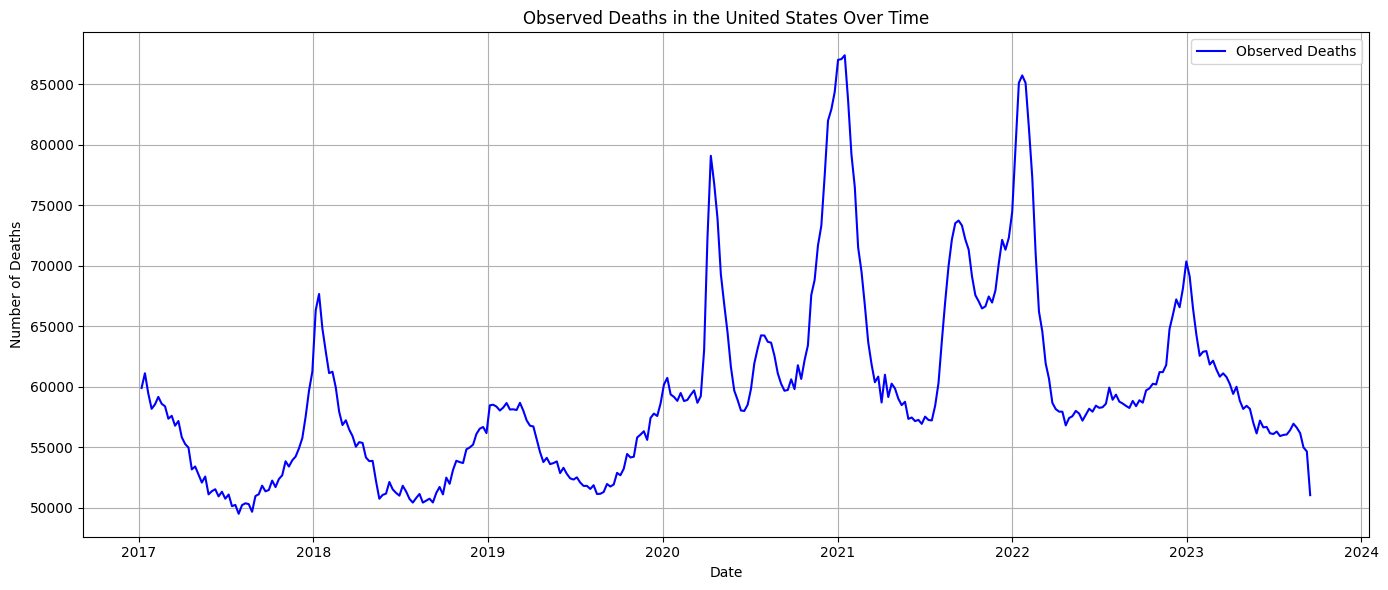

In [ ]:
# 1.b)
# Q: Plot y. Do you notice any seasonal patterns in the number of deaths over time?
# Hint: Can you use matplotlib to plot this data? You may refer to homework 1
# for an example of how to do so. Remember to label your axes and plots!
# --- YOUR CODE HERE ---
plt.figure(figsize=(14, 6))
plt.plot(y.index, y.values, label="Observed Deaths", color='blue')
plt.title("Observed Deaths in the United States Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Deaths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# --- YOUR CODE ENDS ---

**From the above graph**

* We can see peak in deaths during **Covid**, and the seasonality varies as per the different covid waves during 2020-early 2022.

* All in All, the cyclical pattern can be due to **seasonal illnesses**.
For example, during winter months, there's an increase in influenza and other respiratory diseases, leading to higher number of deaths, especially among vulnerable populations like the elderly, this can be yearly cyclical pattern

* Therefore from the above statement, we can say during winters there are more deaths.

* Seasonal factors like heatwaves in summer or extreme cold in winter

* Traveling or gatherings during holidays leading to more accidents or disease spread.

* We can also see that, there is overall increasing cyclical pattern, and also decreasing - this might be due to increasing population (for hikes) and healthcare improvements (for decreasing trends).

In [ ]:
# 1.c)
# Q: Fit a linear regression between y and a variable x that contains the values
# of y but from one earlier timestep.
from sklearn.linear_model import LinearRegression

# Shift the values of y by one step to obtain x
x = y.shift(1)[1:].to_numpy().reshape(-1, 1)

# The first data point in y doesn't have a data point that came before it
# Remove that data point
y = y[1:].to_numpy()

# Similarly to what we did above, use sklearn to create a LinearRegression model
# and store that model in a variable named reg
# --- YOUR CODE HERE ---
reg = LinearRegression()
# --- YOUR CODE ENDS ---

# How do you fit reg to y and x?
# --- YOUR CODE HERE ---
reg.fit(x, y)
# --- YOUR CODE ENDS ---

LinearRegression()

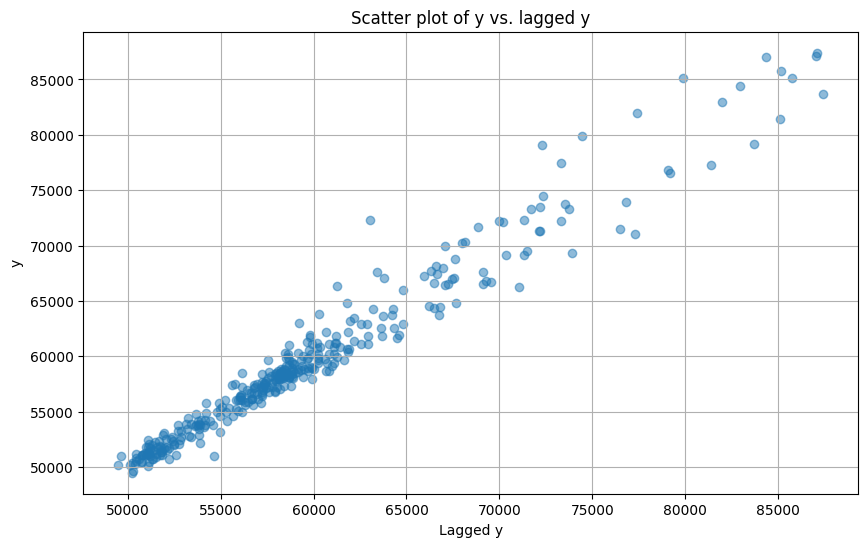

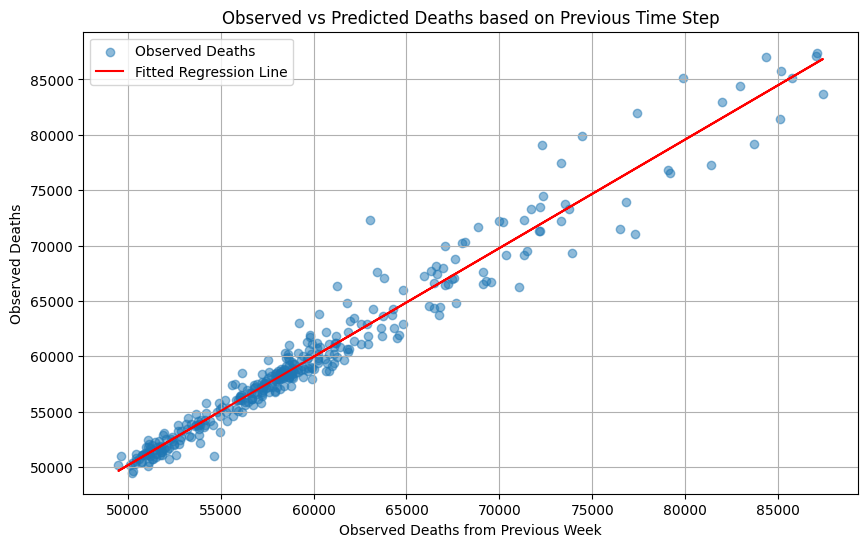

In [ ]:
# 1.d)
# Q: Use matplotlib to plot the two variables on a scatterplot.
# --- YOUR CODE HERE ---
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.title('Scatter plot of y vs. lagged y')
plt.xlabel('Lagged y')
plt.ylabel('y')
plt.grid(True)
plt.show()
# --- YOUR CODE ENDS ---

# How can you get the values of y predicted by reg given x as input?
# Store those values in a variable named pred_values
# --- YOUR CODE HERE ---
pred_values = reg.predict(x)
# --- YOUR CODE ENDS ---

# Plot the fitted regression curve on the same plot.
# This can be done by plotting pred_values vs x on the same plot
# --- YOUR CODE HERE ---
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Observed Deaths', alpha=0.5)
plt.plot(x, pred_values, color='red', label='Fitted Regression Line')
# --- YOUR CODE ENDS ---

# Remember to label your figure!
# --- YOUR CODE HERE ---
plt.title('Observed vs Predicted Deaths based on Previous Time Step')
plt.xlabel('Observed Deaths from Previous Week')
plt.ylabel('Observed Deaths')
plt.legend()
plt.grid(True)
plt.show()
# --- YOUR CODE ENDS ---

**1. Scatter plot of y vs. lagged y:**

  * The scatter plot suggests a strong linear relationship between the number of deaths in a week and the number of deaths in the previous week.
  * The points cluster around a straight line, which indicates that the number of deaths in one week can be a good predictor of the number of deaths in the following week.

**2. Observed vs Predicted Deaths based on Previous Time Step:**
* Observed deaths (in blue) and the predicted deaths (in red).
* It clearly follows the the observed deaths, stating model is a good fit.
* Fairly accurately predict the number of deaths in a week based on the number of deaths in the previous week.

We can say that there is a strong linear relationship between the number of deaths in a week and the number of deaths in the preceding week or the number of deaths in one week is largely influenced by the number of deaths in the week before.

In [ ]:
# 1.e)
# The following function takes an x array of input features, a y array of ground
# truth labels, and a model and returns an adjusted R^2 score of the model on
# the dataset
def adjusted_r2(x, y, model):
  return 1 - (1 - model.score(x, y)) * (len(y) - 1) / (len(y) - x.shape[1] - 1)

# Use the above function to calculate the adjusted R^2 score of the model on
# x and y and store the results in a variable named first_model_adj_r2
# --- YOUR CODE HERE ---
first_model_adj_r2 = adjusted_r2(x, y, reg)
# --- YOUR CODE ENDS ---

print("Adjusted R2 coefficient: {AdjR2}".format(AdjR2=first_model_adj_r2))

Adjusted R2 coefficient: 0.9579311494948856


**95.8% - strong goodness of fit.**
* Approx 95.8% of the variance in the observed deaths (y) can be explained by the model using the previous week's observed deaths.


## Can we develop a better model?

In [ ]:
# 2.a)
# Q: As in the previous part, build an AR(2) model using linear regression.
# Shift the data to create aligned x and y variables
x = pd.concat([df["United States"].shift(2), df["United States"].shift(1)],
              axis=1)[2:].to_numpy()
y = df["United States"][2:].to_numpy()

# Create a LinearRegression model and store it in a variable named reg2
# --- YOUR CODE HERE ---
reg2 = LinearRegression()
# --- YOUR CODE ENDS ---

# How do you fit reg2 to x and y?
# --- YOUR CODE HERE ---
reg2.fit(x, y)
# --- YOUR CODE ENDS ---

LinearRegression()

In [ ]:
# 2.b)
# Use the adjusted_r2 function to calculate the adjusted R^2 score of reg2
# on x and y and store the results in a variable named second_model_adj_r2
# --- YOUR CODE HERE ---
second_model_adj_r2 = adjusted_r2(x, y, reg2)
# --- YOUR CODE ENDS ---

print("Adjusted R2 coefficient: {AdjR2}".format(AdjR2=second_model_adj_r2))

Adjusted R2 coefficient: 0.9723444330032064


**97.23% strong goodness fit**
* The value is now more closer to 1, defining strong explanatory power.

* AR(1) model had 0.9579 and AR(2) now has 0.9723.

* AR(2) captures more of the variance than AR(1) model.

* More lag could increase the fit, but there can be also a risk of overfitting.

* We can consider techniques like cross validation to validate model performance.

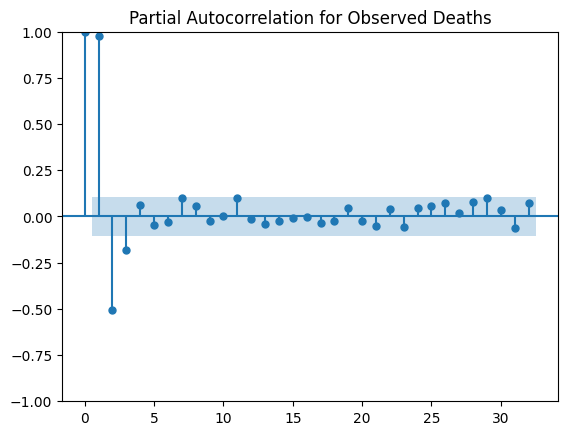

In [ ]:
# 2.c)
# Q: Using the statsmodels library, plot the partial autocorrelation function of
# the time series (D_t) (variable y)
from statsmodels.graphics.tsaplots import plot_pacf

# Just one line of code (yes, it's as obvious as it looks)
# --- YOUR CODE HERE ---
plot_pacf(y, lags=32, title="Partial Autocorrelation for Observed Deaths").show()
# --- YOUR CODE ENDS ---

In [ ]:
# 2.d)
# Use the AR(2) model to forecast the number of deaths in the US one week past
# the end of the provided dataset.
import datetime

most_recent_deaths = df["United States"][-2:].to_numpy()

# How would you use reg2 to predict the death count one week past the end of the
# dataset based on the most recent deaths?
# Note 1: make sure to wrap the data in a list before passing it to the required
# function!
# Note 2: please store your prediction in a variable named prediction
# --- YOUR CODE HERE ---
prediction = reg2.predict([most_recent_deaths])
# --- YOUR CODE ENDS ---

# The function you used above returns a list of predictions, containing one
# element only this time. Extract that one element.
prediction = prediction[0]

# Compute the date one week past the end of the dataset
last_date = df.index[-1]
future_date = last_date + datetime.timedelta(days=7)
print("According to our prediction, at {date}".format(date=future_date) +
      ", there will be {p} deaths during the week".format(p=prediction))

According to our prediction, at 2023-09-23 00:00:00, there will be 49157.84331430184 deaths during the week
